In [1]:
from os import path, listdir

import h5py
from ipywidgets import IntSlider, interact, Dropdown
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.io import loadmat
%matplotlib notebook

## Plot map and raw temporal profile

In [3]:
invalid_units = ['temp_{}'.format(k) for k in np.loadtxt('../data/processed_protocols/list_remove.txt', dtype=int)]

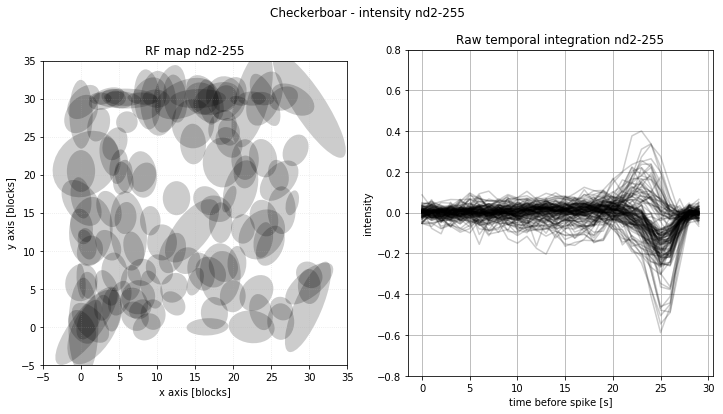

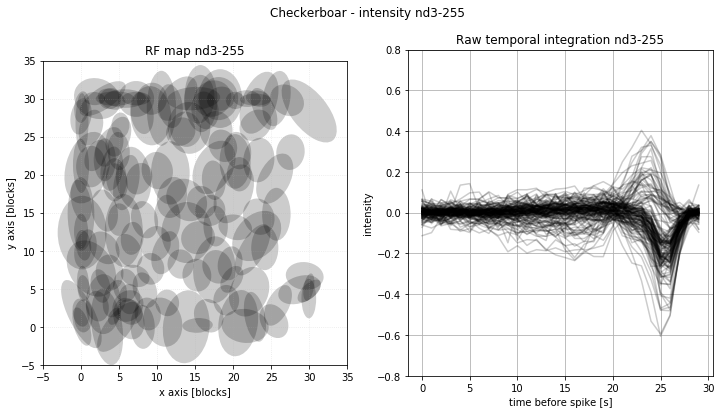

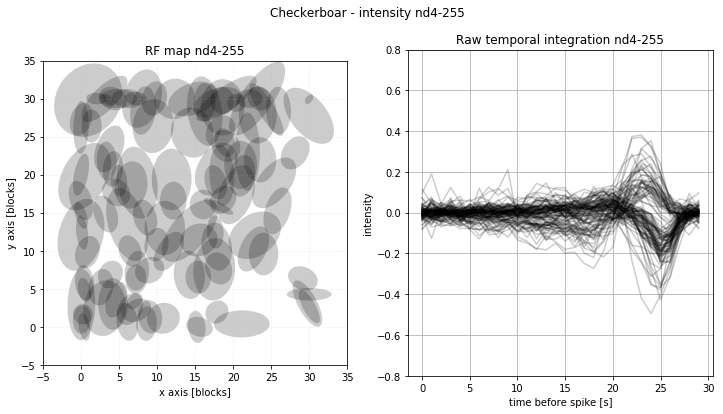

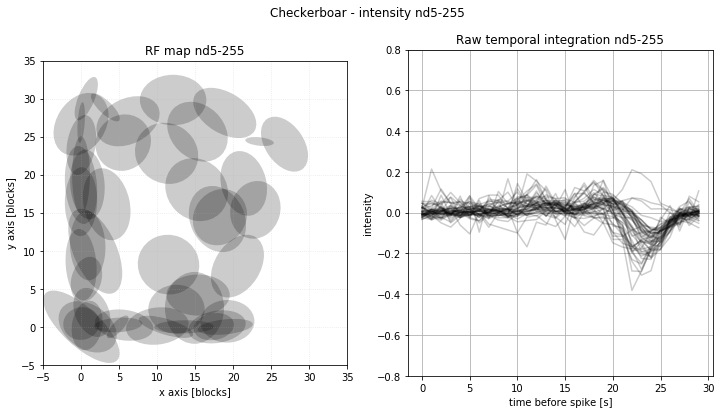

In [5]:
intensities = ['nd2-255', 'nd3-255', 'nd4-255', 'nd5-255']
ffile  = '../data/processed_protocols/MR-0092t2_modified_analysis_of_protocols_150um_merge.hdf5'
output_file = '../reports/fig/sta/map_and_raw_temporal_{}_modified.png'


with h5py.File(ffile,'r') as protocols:
    for intensity in intensities:
        fig, (ax_map, ax_traw) = plt.subplots(1,2, figsize=(12, 6))
        fig.suptitle('Checkerboar - intensity {}'.format(intensity))
        spatial_group = '/sta/{}/spatial/char/'.format(intensity)
        raw_group = '/sta/{}/raw/'.format(intensity)
        valid_group = '/sta/{}/valid/'.format(intensity)
        
        for key in protocols[spatial_group]:
            angle, a, b, x0, y0, snr, frame = protocols[spatial_group+key][...]        
            traw = protocols[raw_group+key][:,int(round(y0)),int(round(x0))]
            #if valid_group in protocols:
            if key not in invalid_units:
                #if protocols[valid_group+key][...]:
                if snr >= 3:
                    pellipse = patches.Ellipse((x0,y0),a*2,b*2,angle=angle,facecolor='k',alpha=0.2, edgecolor='none')
                    ax_map.add_patch(pellipse)
                    # ax.annotate(kchar['name'],xy=(x0,y0),fontsize=7, color=np.random.rand(3,))
                    ax_traw.plot(traw, alpha=0.2, c='k')
#            else:
#                if snr >= 4:
#                    pellipse = patches.Ellipse((x0,y0),a*2,b*2,angle=angle,facecolor='k',alpha=0.2, edgecolor='none')
#                    ax_map.add_patch(pellipse)
#                    # ax.annotate(kchar['name'],xy=(x0,y0),fontsize=7, color=np.random.rand(3,))
#                    ax_traw.plot(traw, alpha=0.2, c='r')

        ax_traw.set(xlabel='time before spike [s]', ylabel='intensity',
                    ylim=[-0.8,0.8], title='Raw temporal integration '+intensity)
        ax_traw.grid()
        ax_map.set(xlim=[-5,35], ylim=[-5,35], xlabel='x axis [blocks]',
               ylabel='y axis [blocks]', aspect=1, title='RF map '+intensity)
        ax_map.grid(alpha=0.3,linestyle=':')
        fig.savefig(output_file.format(intensity))
plt.show()

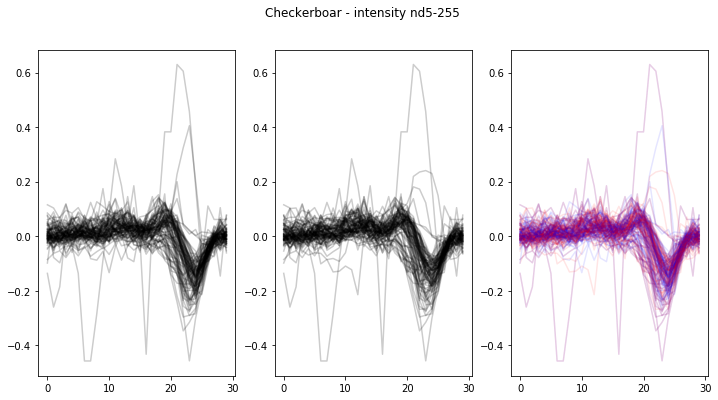

In [15]:
intensity = 'nd5-255'
ffile  = '../data/MR-0092t2_analysis_of_protocols.hdf5'
spatial_group = '/sta/{}/spatial/char/'.format(intensity)
raw_group = '/sta/{}/raw/'.format(intensity)
valid_group = '/sta/{}/valid/'.format(intensity)

fig, (ax_map, ax_traw, ax_togh) = plt.subplots(1,3, figsize=(12,6))
fig.suptitle('Checkerboar - intensity {}'.format(intensity))

with h5py.File(ffile,'r') as protocols:
    for key in protocols[spatial_group]:
        angle, a, b, x0, y0, snr, frame = protocols[spatial_group+key][...]        
        traw = protocols[raw_group+key][:,int(round(y0)),int(round(x0))]
        max_resp = protocols[raw_group+key][frame]
        ym_0, xm_0 = np.unravel_index(np.argmax(np.abs(max_resp), axis=None), max_resp.shape)
        traw_max = protocols[raw_group+key][:,ym_0, xm_0]
        
#         if protocols[valid_group+key][...]:
        if snr>4:
            ax_traw.plot(traw, alpha=0.2, c='k')
            ax_map.plot(traw_max, alpha=0.2, c='k')
            ax_togh.plot(traw_max, alpha=0.1, c='b')
            ax_togh.plot(traw, alpha=0.1, c='r')
            
plt.show()

In [22]:
import pandas as pd
import h5py
import numpy as np
from spikelib.utils import datasets_to_array

In [42]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import ColumnDataSource, CDSView, GroupFilter, BooleanFilter

In [63]:
intensities = ['nd5-255',]# 'nd3-255', 'nd4-255', 'nd5-255'
ffile  = '../data/MR-0092t2_analysis_of_protocols.hdf5'



with h5py.File(ffile,'r') as protocols:
    for intensity in intensities:
        spatial_group = '/sta/{}/spatial/char/'.format(intensity)
        c_array, c_key = datasets_to_array(protocols[spatial_group])
        df = pd.DataFrame(c_array, index=c_key, columns=['angle', 'a', 'b', 'x0', 'y0', 'snr', 'frame'])

df['angle_rad'] = np.radians(df['angle'])
df.loc[:,'a'] = df['a']*2*50
df.loc[:,'b'] = df['b']*2*50
df.loc[:,'x0'] = df['x0']*50
df.loc[:,'y0'] = df['y0']*50
char_cds = ColumnDataSource(df)

In [64]:

snr_filter = df.snr > 3
data_filter = CDSView(source=char_cds, filters=[BooleanFilter(snr_filter)])


In [75]:
output_notebook()
fig = figure(plot_width=600, plot_height=600, x_range=(-4*50, 35*50), y_range=(-4*50, 35*50))
fig.ellipse(x='x0', y='y0', width='a', height='b',
       angle='angle', angle_units='deg', alpha=0.2, source=char_cds, view=data_filter)
show(fig)

Loading BokehJS ...